In [8]:
import pandas as pd

# 读取csv文件
df = pd.read_csv('data/USA/usa whole.csv')

# 将日期列转换为日期时间类型
df['date'] = pd.to_datetime(df['date'])

# 按照日期对负载数据进行分组，并计算平均负载
avg_loads = df.groupby('date')['load'].mean()

# 创建新的DataFrame，包含日期和平均负载
new_df = pd.DataFrame({'date': avg_loads.index, 'avg_load': avg_loads.values})

new_df.to_csv('data/USA/usa whole_avg.csv', index=False, columns=['date', 'avg_load'])

In [1]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import optim
from torch.nn import functional as F


from nbeats_pytorch.model import NBeatsNet
from trainer_pytorch import save

warnings.filterwarnings(action='ignore', message='Setting attributes')


In [2]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

class CustomLoss(torch.nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,x,y):
        my_loss = torch.mean(torch.abs((x - y)/y))
        return  my_loss


               avg_load
date                   
2015-07-02  84085.66667
2015-07-03  79334.16667
2015-07-04  76496.79167
2015-07-05  80533.83333
2015-07-06  92807.25000
600
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=64, thetas_dim=2, backcast_length=12, forecast_length=31, share_thetas=False) at @3059119847624
     | -- GenericBlock(units=64, thetas_dim=2, backcast_length=12, forecast_length=31, share_thetas=False) at @3059119847624
     | -- GenericBlock(units=64, thetas_dim=2, backcast_length=12, forecast_length=31, share_thetas=False) at @3059119847624
| --  Stack Seasonality (#1) (share_weights_in_stack=True)
     | -- SeasonalityBlock(units=64, thetas_dim=31, backcast_length=12, forecast_length=31, share_thetas=True) at @3059119849160
     | -- SeasonalityBlock(units=64, thetas_dim=31, backcast_length=12, forecast_length=31, share_thetas=True) at @3059119849160
     | -- SeasonalityBlock(units=64, thetas_dim=31, backcast_length=12,

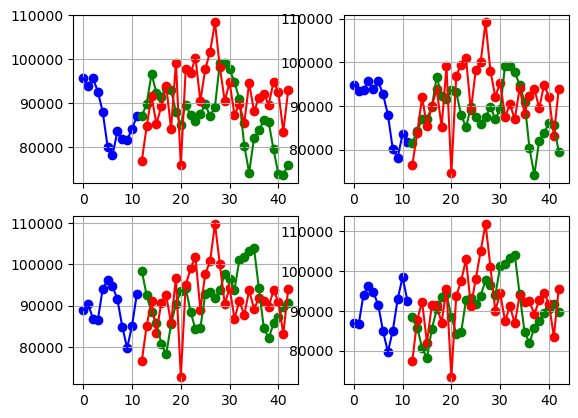

epoch = 0000, grad_step = 000038, tr_loss (epoch) = 300.069, te_loss (epoch) = 12.502


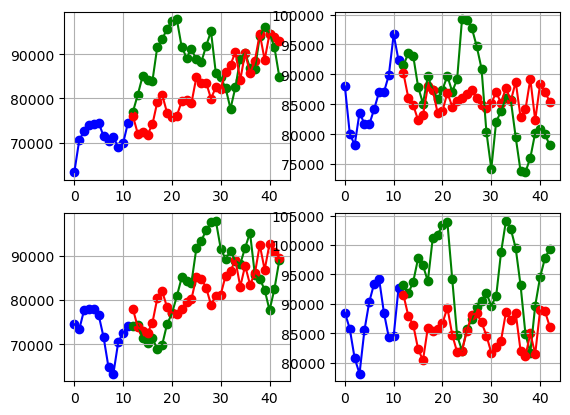

epoch = 0100, grad_step = 003838, tr_loss (epoch) = 5.852, te_loss (epoch) = 6.051


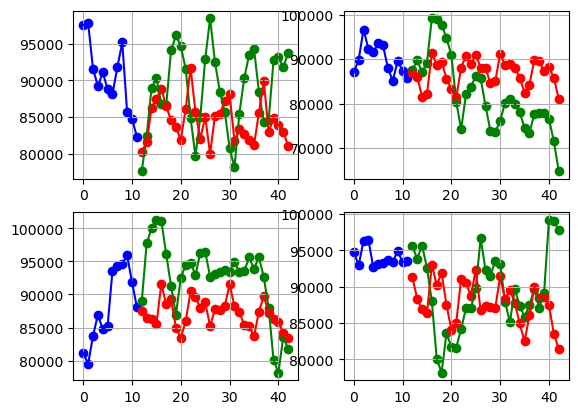

epoch = 0200, grad_step = 007638, tr_loss (epoch) = 5.353, te_loss (epoch) = 6.091


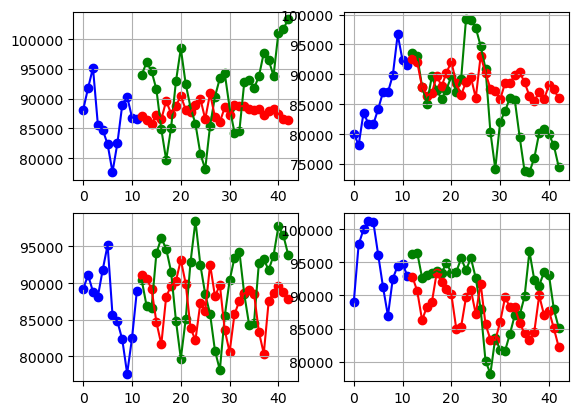

epoch = 0300, grad_step = 011438, tr_loss (epoch) = 5.123, te_loss (epoch) = 6.137


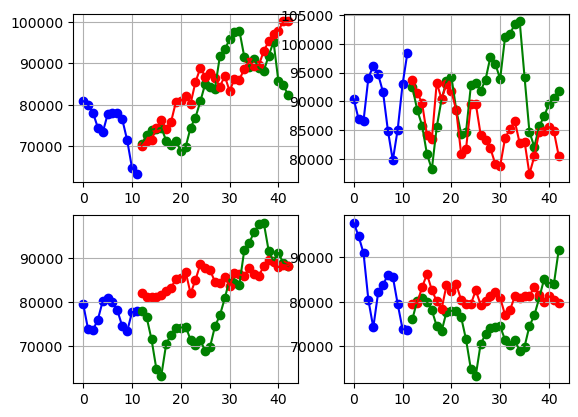

epoch = 0400, grad_step = 015238, tr_loss (epoch) = 4.838, te_loss (epoch) = 6.226


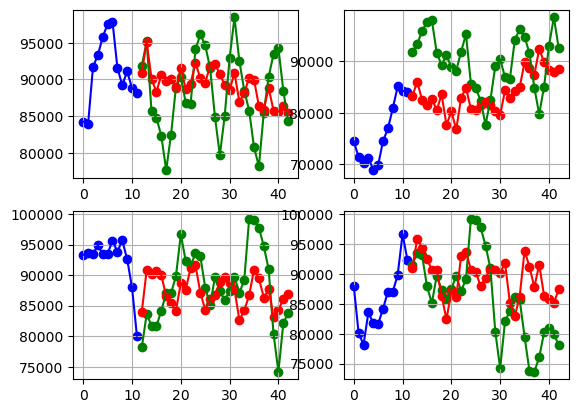

epoch = 0500, grad_step = 019038, tr_loss (epoch) = 4.843, te_loss (epoch) = 6.503


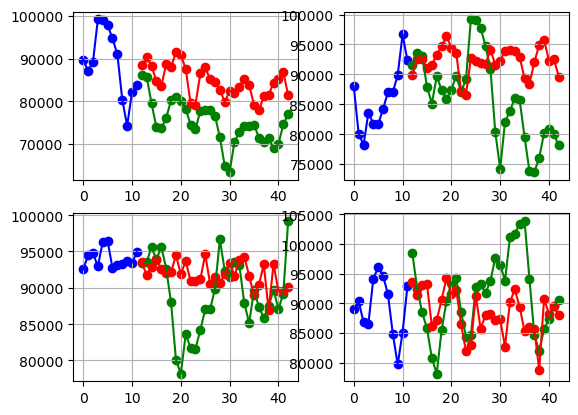

epoch = 0600, grad_step = 022838, tr_loss (epoch) = 3.861, te_loss (epoch) = 6.886


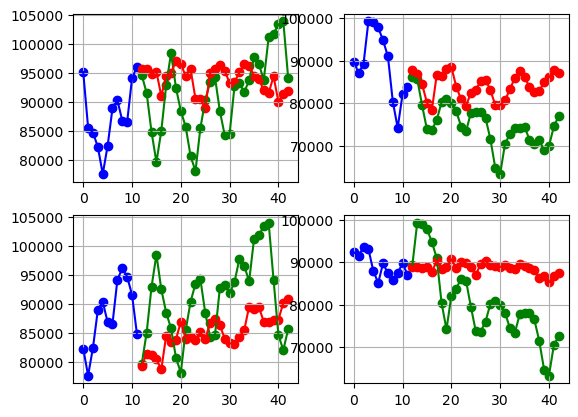

epoch = 0700, grad_step = 026638, tr_loss (epoch) = 3.514, te_loss (epoch) = 7.202


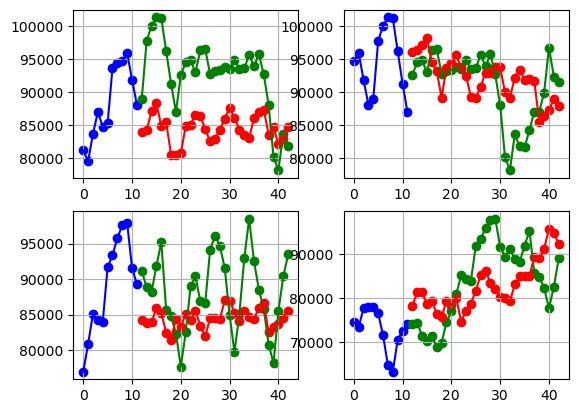

epoch = 0800, grad_step = 030438, tr_loss (epoch) = 3.446, te_loss (epoch) = 7.135


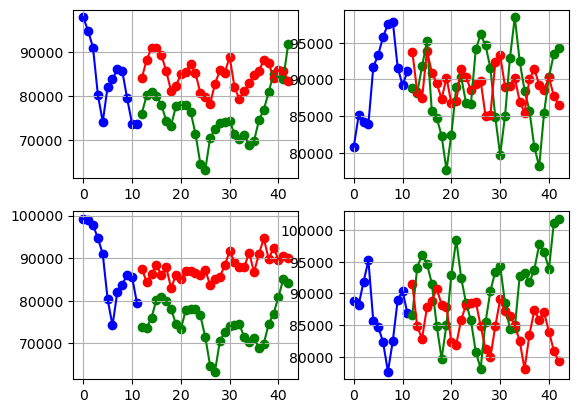

epoch = 0900, grad_step = 034238, tr_loss (epoch) = 3.180, te_loss (epoch) = 8.040
avg [84530.9609375, 82136.75390625, 83326.30989583333, 86048.78515625, 87208.2109375, 89088.171875, 88322.49107142857, 83764.46484375, 83367.17621527778, 88451.86171875, 90329.83025568182, 90709.69986979167, 91265.10817307692, 89810.40680803571, 85013.40625, 84198.92138671875, 89306.59053308824, 90863.42621527778, 91162.61554276316, 91093.38984375, 89672.44568452382, 85964.35617897728, 85045.14673913043, 89114.50390625, 91214.1771875, 91253.80168269231, 91131.50839120371, 90212.23911830357, 86943.0864762931, 85647.096875, 88733.40398185483, 90476.16507056452, 90483.42741935483, 90445.63256048386, 89878.59979838709, 87444.6995967742, 86805.51108870968, 89450.38256048386, 90708.33845766129, 90742.42212701614, 90550.2925907258, 89828.89969758065, 87501.2101814516, 86494.4304435484, 88100.4652217742, 88948.24243951614, 88780.47454637097, 88380.35534274194, 87798.26612903226, 86046.45866935483, 85510.63205645

In [8]:
def main():
    forecast_length = 31
    backcast_length = 12
    # backcast_length = forecast_length*7
    batch_size = 16  # greater than 4 for viz

    electric = pd.read_csv('data/USA/usa whole_avg - 8.csv', index_col=0, parse_dates=True)

    print(electric.head())
    electric = electric.values.flatten()  # just keep np array here for simplicity.

    # data backcast/forecast generation.
    x, y = [], []
    for epoch in range(backcast_length, len(electric) - forecast_length):

        x.append(electric[epoch - backcast_length:epoch])
        y.append(electric[epoch:epoch + forecast_length])
    x = np.array(x)
    y = np.array(y)

    # split train/test.
    c = int(len(x) * 0.8)
    print(c)

    x_train, y_train = x[:c], y[:c]
    x_test, y_test = x[c:], y[c:]

    # normalization.  归一化
    norm_constant = np.max(x_train)
    x_train, y_train = x_train / norm_constant, y_train / norm_constant
    x_test, y_test = x_test / norm_constant, y_test / norm_constant

    # model
    net = NBeatsNet(
        stack_types=(NBeatsNet.GENERIC_BLOCK,NBeatsNet.SEASONALITY_BLOCK,NBeatsNet.TREND_BLOCK),
        forecast_length=forecast_length,
        backcast_length=backcast_length,
        # nb_blocks_per_stack=4,
        hidden_layer_units = 64,
        thetas_dim=(2,8,3),
        share_weights_in_stack=True
    )
    # net = torch.load("model(wu).pth")
    # optimiser = optim.Adam(lr=1e-4, params=net.parameters())
    optimiser = optim.Adam(lr=0.002, params=net.parameters())


    grad_step = 0
    # best_state_dict = None
    # best_loss = float('inf')
    for epoch in range(1000):
        # train.
        net.train()
        train_loss = []
        for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
            grad_step += 1
            optimiser.zero_grad()
            _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
            A=CustomLoss()
            # loss = A(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
            loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
            train_loss.append(loss.item())
            loss.backward()
            optimiser.step()
        train_loss = np.mean(train_loss)

        # test.
        net.eval()
        _, forecast = net(torch.tensor(x_test, dtype=torch.float))
        B=CustomLoss()
        # test_loss = B(forecast, torch.tensor(y_test, dtype=torch.float).to(net.device)).item()
        test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
        p = forecast.detach().numpy()
        if epoch % 100 == 0:
            subplots = [221, 222, 223, 224]
            plt.figure(1)
            for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
                ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
                plt.subplot(subplots[plot_id])
                plt.grid()
                plot_scatter(range(0, backcast_length), xx, color='b')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
            plt.show()

            with torch.no_grad():
                save(net, optimiser, grad_step)

            # if test_loss < best_loss:
            #     best_loss = test_loss
            #     # best_state_dict = nbeats.state_dict()
            #     best_state_dict = net.state_dict()


            print(f'epoch = {str(epoch).zfill(4)}, '
                  f'grad_step = {str(grad_step).zfill(6)}, '
                  f'tr_loss (epoch) = {1000 * train_loss:.3f}, '
                  f'te_loss (epoch) = {1000 * test_loss:.3f}')

    B = forecast.flatten()
    C= B * norm_constant
    NC = C.detach().numpy()
    NNC = NC.tolist()
    # Text=NNC[len(NNC)-31::]
    # print('Text',Text)

    B=forecast_length -1
    avg=[]
    # 当len（forecast）< forecast_length
    if  forecast_length>len(forecast):
       for i in range(0,len(forecast)+forecast_length-1):
          if i == 0:
             avg.append(NNC[i])
             pass

          elif 0<i<=len(forecast)-1:
             N = np.mean(NNC[i:forecast_length * i + 1:B])
             avg.append(N)
             pass

          elif forecast_length-1>=i>len(forecast)-1:
             avg.append(np.mean(NNC[i:forecast_length * i + 1:B]))
             pass

          elif len(forecast) + forecast_length - 2 > i > forecast_length-1:
             j = i - forecast_length + 1
             avg.append(np.mean(NNC[i + B * j:len(NNC):B]))
             pass

          else:
             c = i - forecast_length+1
             avg.append(NNC[ i + c * B ])
             pass
       pass

    # 当len（forecast）= forecast_length
    elif forecast_length == len(forecast):
        for i in range(0,len(forecast)+forecast_length-1):
          if i == 0:
             avg.append(NNC[i])
             pass

          elif 0<i<=len(forecast)-1:
             N = np.mean(NNC[i :forecast_length * i + 1 : B])
             avg.append(N)
             pass

          elif len(forecast) + forecast_length - 2 > i > forecast_length-1:
             j = i - forecast_length + 1
             avg.append(np.mean(NNC[i + B * j:len(NNC):B]))
             pass

          else:
             c = i - forecast_length+1
             avg.append(NNC[ i + c * B ])
             pass
        pass

    # 当len（forecast）> forecast_length
    else:
        for i in range(0,len(forecast)+forecast_length-1):
          if i == 0:
             avg.append(NNC[i])
             pass

          elif 0<i<=forecast_length-1:
             N = np.mean(NNC[i:forecast_length * i + 1:B])
             avg.append(N)
             pass

          elif len(forecast)>i>forecast_length-1:
             t = i - forecast_length + 1
             avg.append(np.mean(NNC[i + B * t : len(NNC) - (len(forecast)-i) * forecast_length + 1 : B]))
             pass

          # 在这里下端触底了
          elif len(forecast) + forecast_length - 2 > i >= len(forecast)-1:
             j = i - forecast_length + 1
             avg.append(np.mean(NNC[i + B * j:len(NNC) - 1 : B]))
             pass

          else:
             c = i - forecast_length+1
             avg.append(NNC[ i + c * B ])
             pass
        pass

    print('avg',avg)
    print(type(avg))
    print('len(avg)',len(avg))

    Text=avg[len(avg)-31::]
    print('Text',Text)


    TRU = electric[len(electric)-31::]
    print('TRU',TRU)
    print('TRU',len(TRU))
    print(type(TRU),type(TRU))






    # MAPE

    APE=[]
    for day in range(len(TRU)):
        per_err = (TRU[day] - Text[day]) / TRU[day]
        per_err = abs(per_err)
        APE.append(per_err)
        MAPE = sum(APE)/len(APE)
    print(len(TRU),'天总共预测电量的mape的平均值')
    print('mape :',round(MAPE, 2))
    print('mape % :',round(MAPE*100, 2),'%')
    print('---------------------------------------------')
    EVE=[]
    for day in range(len(TRU)):
        per_err1 = abs((TRU[day] - Text[day]) / TRU[day])
        EVE.append(per_err1*100)
    print(EVE)

    torch.save(net,'N-BEATS(usa_SUMMER).pth')









if __name__ == '__main__':
    main()